# Plotting predictions

This code plots the [distribution of prediction errors and confidence intervals for all counties](../outputs/ESM_9.tiff), predictions for the [present](../outputs/ESM_11.tiff) and [past](../outputs/Fig4.tiff) distribution of buckwheat, as well as the [suitability of locations with buckwheat overlaid on the overall suitability of environmental conditions across time](../outputs/Fig3.tiff). 

In [92]:
### Load libraries
library(here)
library(rgeos)
library(geosphere)
library(rgdal)
library("ggplot2")
library("tidyr")
library(raster) # for crs
library(ggbeeswarm)
library(tmap)
library(sf)
library(stringr)

In [2]:
### Load utility functions and themes
source(here("R","getNicheOutline.R"))
source(here("R","theme_tmaps.R"))

In [3]:
### Define paths

# Define imputs paths:

path2locations<-here("data","ESM_2.csv") # Buckwheat's occurrence records
path2prod<-here('data','Prd_by_county.csv')
path2china<-here('raw_data','CHN_adm')
path2pred_summary <- here("outputs","05_03_Predictions_summary.csv")

# Output files:
path2diffintPlot<-here('outputs','ESM_9.pdf')
path2check_niche<-here('data',"potential_niche_check")
path2niche<-here('data',"potential_niche")
path2checkMaps<-here('outputs','ESM_11.tiff')
path2predMaps<-here('outputs','Fig4.tiff')
path2violin<-here('outputs','Fig3.tiff')

In [ ]:
### Import relevant dataset
# Import data about fagopyrum in China:
locations<-read.csv(path2locations)
# Import predictions summary
pred_summary<-read.csv(path2pred_summary)
# Import the outer border of China
outer_border<-st_read(dsn=path2china,layer='CHN_adm0')
# Import the spatial polygons data frame of counties:
china<-readOGR(dsn=path2china,layer='CHN_adm3')
# Import production data
prd<-read.csv(path2prod,row.names=1)

In [6]:
# Trnsform location data data into a spatial points data.frame
coordinates(locations)<-~longitude+latitude
locations<-subset(locations,Country=="China")

In [7]:
# Assign occurrence records to time slices (up till 8000 BP)

start=1500
loc<-subset(locations,end_date<=1500)
loc$period <- "1000 BP"
for (i in c(1:7)){
    sub<-subset(locations,(end_date<=start+1000 & end_date>start)| (start_date>start & start_date<=start+1000 ))
    start=start+1000
    if(nrow(sub)>0){
       sub$period <- paste(start-500,"BP",sep=" ")
       loc<-rbind(loc,sub)}
}

## Prepare data for plots

This merge predictions with the spatial polygons, and assigns predictions to sites with buckwheat. It also calculates the difference between predictions and the observations and the confidence interval.


In [8]:
### Get the log means predictions, 0.05, and 0.95 quantiles for each county in a separate variables
mean_names<-colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("mean",colnames(pred_summary))]
means<-pred_summary[,colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("mean",colnames(pred_summary))]]
q5_names<-colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("X5",colnames(pred_summary))]
q5<-pred_summary[,colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("X5",colnames(pred_summary))]]
q95_names<-colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("X95",colnames(pred_summary))]
q95<-pred_summary[,colnames(pred_summary)[grepl("log",colnames(pred_summary))&grepl("X95",colnames(pred_summary))]]

In [9]:
### Combine the predictions with the spatial polygons data frame of counties in china and observations
logArea<-prd$logArea
china@data<-cbind(china@data,means,q5,q95,logArea)

In [10]:
### Calculate the predictions error and the confidence interval size for each county in china
china@data$difference<-china@data$mean_pred_log - china@data$logArea
china@data$interval<-china@data$X95._log - china@data$X5._log

In [11]:
### Bind the location data, with the predictions for counties in which buckwheat was found:
proj4string(loc) <- crs(china)
pred_data<-sp::over(loc,china)
loc@data<-cbind(loc@data,pred_data)

In [12]:
### Gets the mean predictions, 5th and 95th quantile for period to which each site is dated
loc@data$mean<-NA
loc@data$q5<-NA
loc@data$q95<-NA

# Get all time slices
timeslices <-gsub(" BP","",unique(loc@data$period))

# Loop over all time slices to get mean predictions and confidence intervals for it
for (i in timeslices){
loc@data[grep(i,loc@data$period),c('mean','q5','q95')]<-loc@data[grep(i,loc@data$period),grep(paste("_",i,sep=""),colnames(loc@data))]}

In [13]:
### Get the minimum predictions for all sites, except for those with F. tataricum

ft<-loc@data[loc@data$Taxonomic_identification=="Fagopyrum tataricum",]$Site_short
threshold<-min(loc@data[!(loc@data$Site_short%in%ft),]$mean,na.rm = TRUE)
threshold05<-min(loc@data[!(loc@data$Site_short%in%ft),]$q5,na.rm = TRUE)
threshold95<-min(loc@data[!(loc@data$Site_short%in%ft),]$q95,na.rm = TRUE)

## Distribution of confidence intervals and diffrence between predictions and observations

In [ ]:
### Gather data by differenc and interval for plotting
di<-gather(china@data[,c('difference','interval')], key = "stat",value="value")

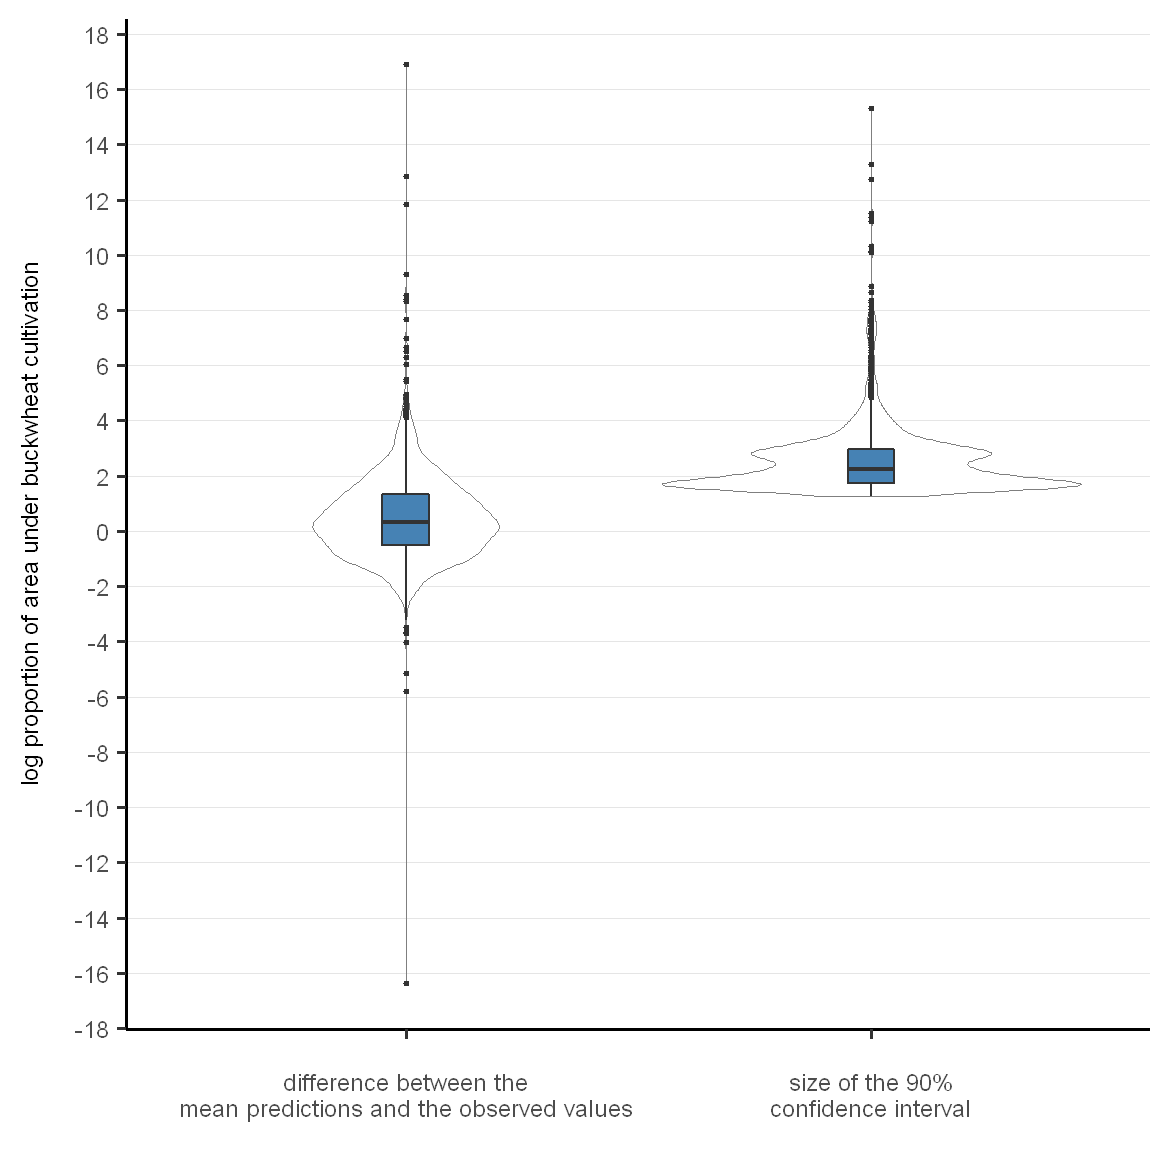

In [46]:
### Plot the distribution of differences and intervals
dip<-ggplot(di, aes(x=stat,y=value)) + 
  geom_violin(data=di, aes(x=stat,y=value),lwd=0.2,color="grey50")+
  geom_boxplot(width=0.1,fill="steelblue",outlier.size=0.4,lwd=0.3)+
  theme_classic()+ 
  theme(panel.grid.major.y = element_line(color="grey90",size=0.2),
          axis.title=element_text(size=7,face="plain"),
          axis.text=element_text(size=7))+
  labs(y="log proportion of area under buckwheat cultivation\n",x="")+
  scale_x_discrete(labels=c("\ndifference between the\nmean predictions and the observed values","\nsize of the 90%\nconfidence interval"))+
  scale_y_continuous(breaks=seq(-20,20,2))

# Optionally plot in jupyter as well
#options(repr.plot.width=4.68,repr.plot.height=4.68,repr.plot.res=250)
dip

In [47]:
height=4.68
width=4.68
ggsave(path2diffintPlot,dip,width = width, height = height)

In [58]:
# Check in how many counties the observed values fall within the 90% confidence interval
table(china@data$mean_pred_log>china@data$X5._log & china@data$mean_pred_log<china@data$X95._log)
# Out of:
nrow(china@data)


TRUE 
2409 

[1] 2409

## Poserior predictions maps

Plot the maps of posterior predictions comparade against the observed values, mean differece and the size of the confidence interval.

In [20]:
### Transform china spatial points dataframe to simple features
china_sf<-st_as_sf(china) 

In [ ]:
### Prepare the outlines of the niche based on the to thresholds for the present distribution and predictions

mp<-as_Spatial(st_union(china_sf[china_sf$mean_pred_log>=threshold,]))
mp<-SpatialPolygonsDataFrame(mp,data=data.frame(id=3,quantile="Mean Predictions",row.names=row.names(mp)))

la<-as_Spatial(st_union(china_sf[china_sf$logArea>=threshold,]))
la<-SpatialPolygonsDataFrame(la,data=data.frame(id=1,quantile="Observed Values",row.names=row.names(la)))

q05p<-as_Spatial(st_union(china_sf[china_sf$X5._log>=threshold05,]))
q05p<-SpatialPolygonsDataFrame(q05p,data=data.frame(id=4,quantile="5th Quantile",row.names=row.names(q05p)))

q95p<-as_Spatial(st_union(china_sf[china_sf$X95._log>=threshold95,]))
q95p<-SpatialPolygonsDataFrame(q95p,data=data.frame(id=2,quantile="95th Quantile",row.names=row.names(q95p)))

In [98]:
### Bind the niches into one sparial polygons data frame
inner_border_check<-rbind(la,q95p,mp,q05p)

In [100]:
### Save the polygons
writeOGR(inner_border_check,dsn=path2niche_check,layer="potential_niche_check",driver="ESRI Shapefile")

In [87]:
# Plot the potential nich predictions and diagnostics for the present distribution
# Define the labels:
columns<-c("logArea","X95._log","mean_pred_log","X5._log")
labels<-c("A: OBSERVED VALUES", "B: PREDICTIONS AT 95TH PERCENTILE","D: MEAN PREDICTIONS","C: PREDICTIONS AT 95TH PERCENTILE","D: PREDICTIONS AT 5TH PERCENTILE")

In [98]:
check_maps<-tm_shape(china) +
    tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.8)+
    # Define the colors of the polygons and the legend
    tm_fill(col=columns, title.col="Period",style="cont",n=20,legend.reverse = TRUE,palette="-RdYlBu",title = "log area\nfraction\nunder\nbuckwheat\ncultivation",showNA = F,midpoint=NA)+
    # Define the facets to draw:
    tm_facets(free.scales=FALSE,free.coords=FALSE,ncol = 2,nrow = 2)+   
    # Add the shape of the predicted niche  
    tm_shape(inner_border_check)+
    tm_borders(col="grey1",lwd=0.8,lty="dashed")+
    tm_facets(by = "id",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=2)+
    # Add the outer border to the plot
    tm_shape(outer_border)+
    tm_borders(col="grey75",lwd=0.8)+
    theme_tmaps+
    # Format layout:
    tm_layout(panel.labels=labels,
              legend.outside.size=0.08,
              legend.outside = TRUE,
              legend.text.size = 0.5,
              panel.label.size = 0.8,
              legend.title.size=0.6,
              panel.label.height=2)


# Make difference maps:
diff_maps<-tm_shape(china)+
    tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.55)+
    tm_fill(col=c("difference","interval"), title.col="Period",style = "cont",legend.reverse = TRUE,palette=c("-RdBu"),title = c("log area\nfraction\nunder\nbuckwheat\ncultivation"),showNA = F)+
    theme_tmaps+
    tm_layout(panel.labels=c("E: DIFFERENCE BETWEEN THE MEAN\nPREDICTIONS AND THE OBSERVED VALEUS","F: SIZE OF THE 90% CONFIDENCE INTERVAL" ),
              legend.outside.size=0.08,
              legend.outside = TRUE,
              legend.text.size = 0.5,
              panel.label.size = 0.6,
              legend.title.size=0.6,
              panel.label.height=2)+
    tm_facets(free.scales=FALSE,nrow=1,ncol=2)+
tm_credits("\n\nCoordinate system: World Geodetic System 1984",position=c("left","bottom"))


cm<-tmap_arrange(check_maps, diff_maps, heights=c(2/3,1/3))

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Variable(s) "difference", "interval" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Variable(s) "difference", "interval" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.



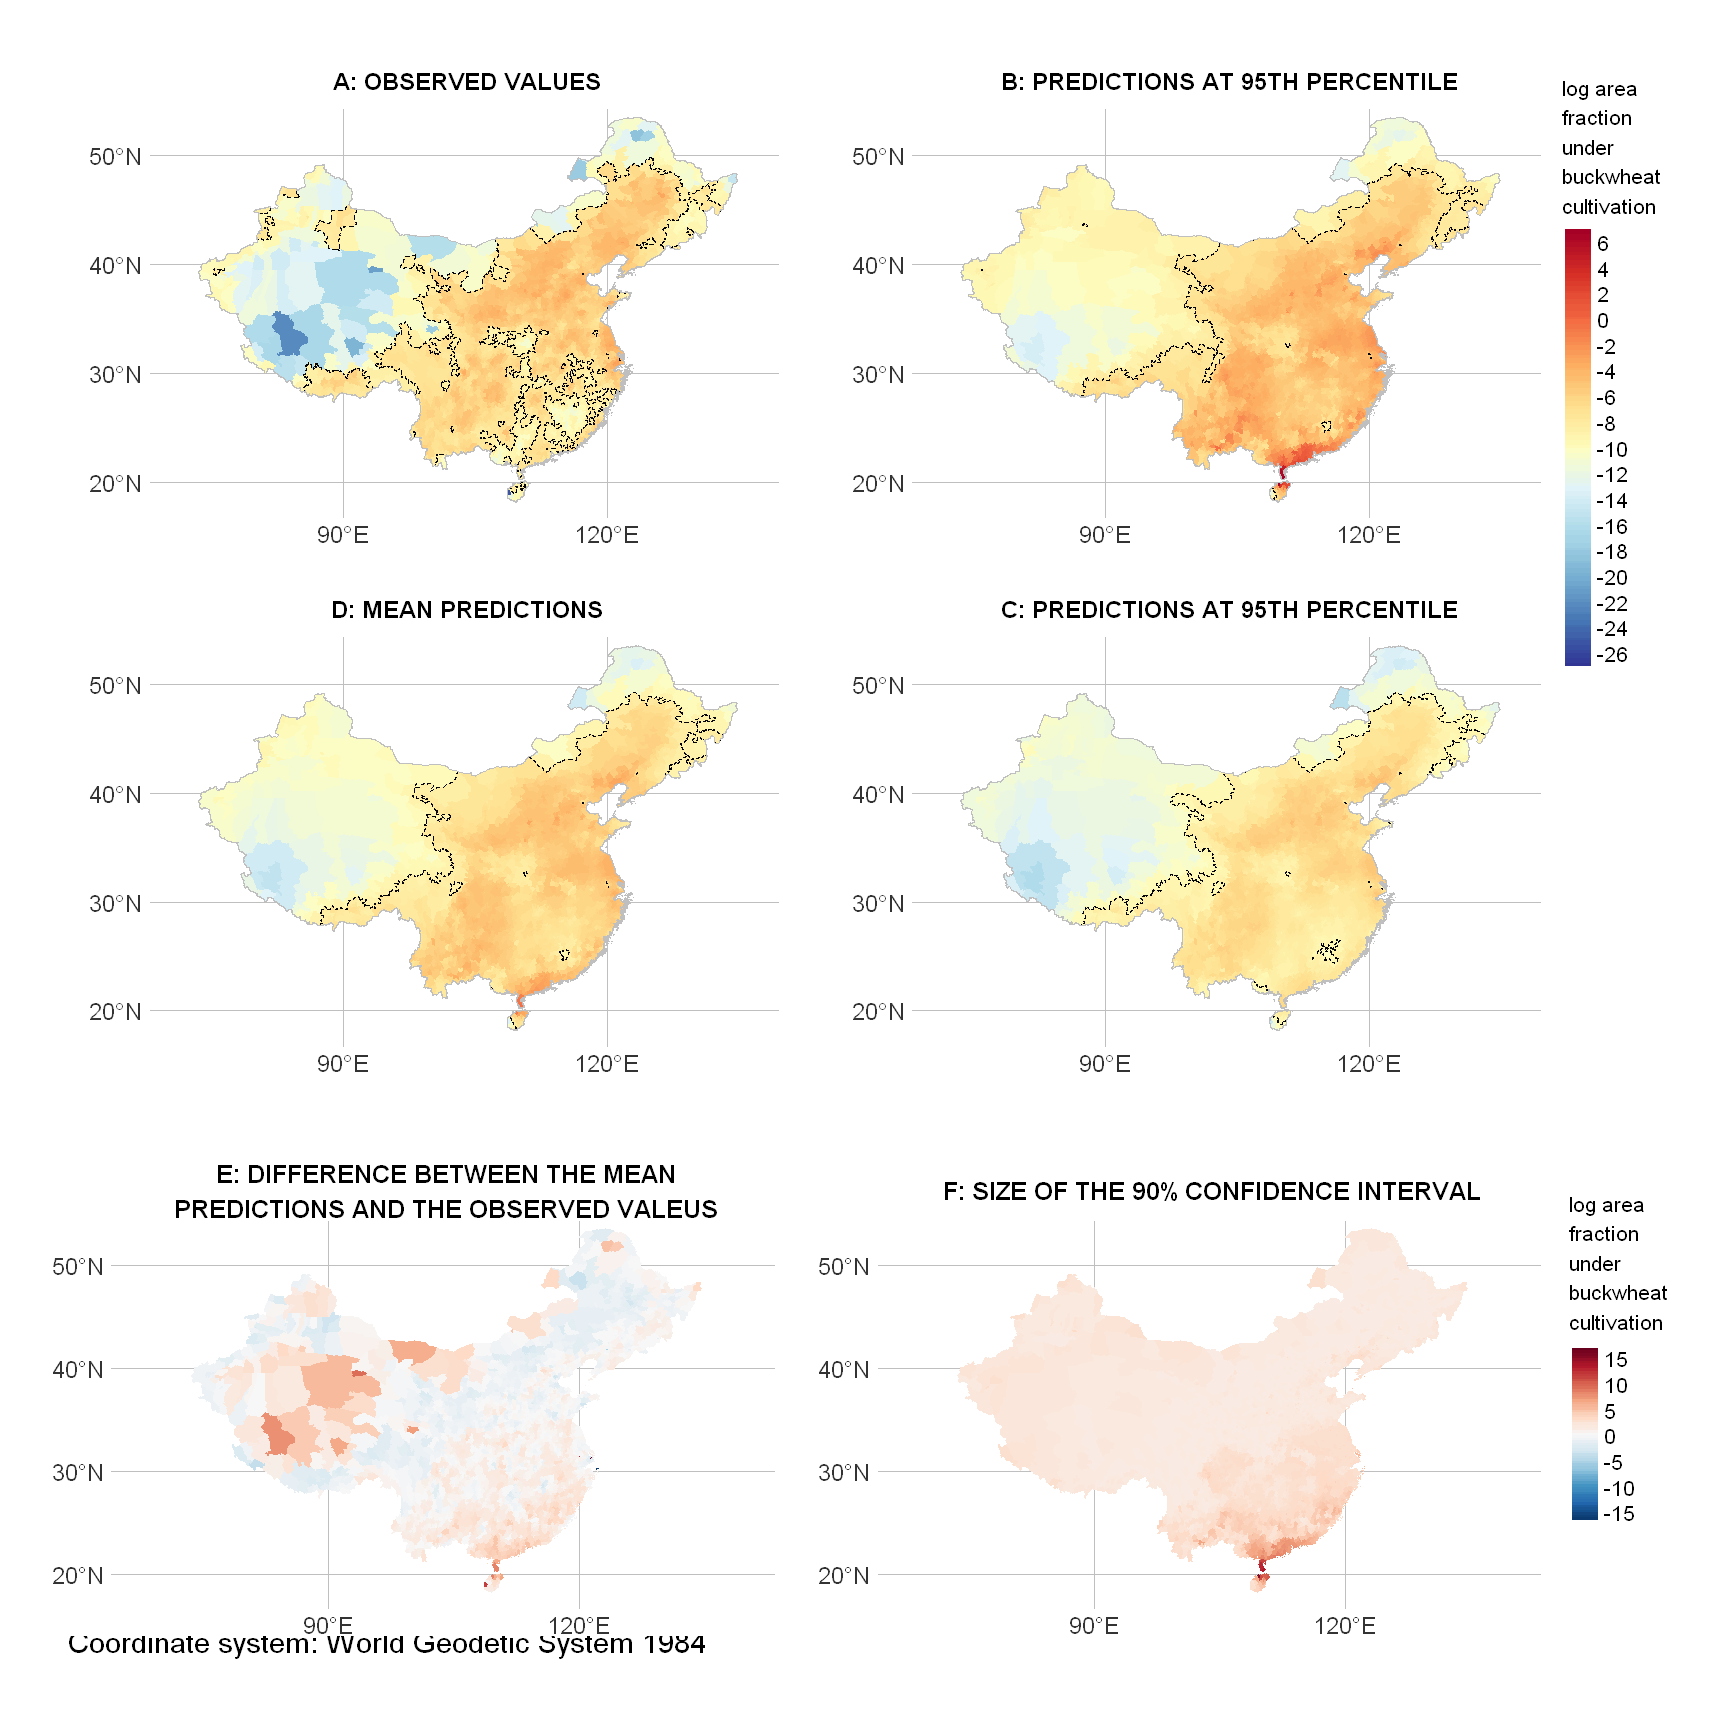

In [103]:
# Optionally plot in jupyter
#options(repr.plot.width=6.85,repr.plot.height=6.85,repr.plot.res=250)
cm

In [ ]:
### Save maps
width=17.4
height=20.4
tmap_save(tm = cm,filename = path2checkMaps,width = width,height = height,units = "cm",dpi = 600)

## Plot predictions for the past 8000 years

In [40]:
### Define variables to calculate niche for all time periods
facets<-paste(seq(1000,8000,1000),"BP")
columns<-colnames(means[2:(length(colnames(means))-1)])

In [ ]:
### Get the niche for all time periods
inner_border<-getNicheOutline(colnames(means[2:(length(colnames(means))-1)]),threshold,threshold_max=NULL,facets,sf_object=china_sf)

In [28]:
### Save the niche for all time priods
writeOGR(a,dsn=path2niche,layer="potential_niche",driver="ESRI Shapefile")

In [29]:
inner_border<-readOGR(here("data","potential_niche"),layer="potential_niche")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\data\potential_niche", layer: "potential_niche"
with 8 features
It has 2 fields


In [35]:
# Plot the potential nich of buckwheat for all 8 time periods:

# Prepare buckwheat locations for plotting
macros<-loc
macros$Sample_type<-as.character(macros$Sample_type)
ft<-macros[macros$Taxonomic_identification=="Fagopyrum tataricum",]$Site_short

macros$Sample_type <- ifelse(macros$Site_short %in% ft,paste("Fagopyrum tataricum",macros$Sample_type),macros$Sample_type )
macros$Sample_type <- tolower(macros$Sample_type)
macros$period<-factor(macros$period,levels=facets)

# Get column with relevant site labels
macros$map_labels <- ifelse(macros$Site_short %in% c(ft,"Sihailongwan Lake")| 
                           (macros$Site_short=="Wangjiadian"& macros$period=="8000 BP"),
                    macros$Site_short,"")
macros$adjx<-ifelse(macros$Site_short=="Kyung-lung Mesa",1,-0.5)
macros$adjy<-ifelse(macros$Site_short=="Kyung-lung Mesa",0.8,-0.8)

In [ ]:
### Get the location of the highest prediction area and the centre of domestication
# Get the coodrinates of county with the highest predictions and it's coordinates

max.s<-subset(china,china@data$mean_pred_8000_log==max(china@data[china@data$NAME_1!="Guangdong",]$mean_pred_8000_log,na.rm=TRUE)) # Exclude the uncertain predictions in the South
max.c = gCentroid(max.s)
# Add coordinates of Snajiang region and put both in the data frame:
reg<-SpatialPointsDataFrame(coords = matrix(c(100.09,max.c$x,27.34,max.c$y),nrow=2,ncol=2), data =data.frame(label=c("A","B"),period=c("8000 BP","8000 BP"), legend=c("inferred centre\nof origin","maximum\nsuitability\narea")),
                         proj4string = CRS(proj4string(max.c)))

reg$period<-factor(reg$period,levels=labels)

In [49]:
pred_maps<-tm_shape(china) +
    # Define the grid form maps drawing
    tm_graticules(lwd = 0.05,col="grey75",n.x=2,n.y=3,labels.size = 0.8)+
    # Define the colors of the polygons and the legend
    tm_fill(col=columns, title.col="Period",style="cont",breaks=seq(-26,6,2),legend.reverse = TRUE,palette="-RdYlBu",title = "log area\nfraction\nunder\nbuckwheat\ncultivation",showNA = F,midpoint=NA)+
    # Define the facets to draw:
    tm_facets(free.scales=FALSE,free.coords=FALSE,ncol = 2,nrow = 4)+   
     # Add the shape of the predicted mean niche  
    tm_shape(inner_border)+
    tm_borders(col="grey10",lwd=1,lty="dashed")+
    tm_facets(by = "id",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=4)+
    # Add the outer border to the plot
    tm_shape(outer_border)+
    tm_borders(col="grey75",lwd=1)+
    # Add the labels of the relevant regions
    tm_shape(reg)+
    tm_text("label",size=1.5)+
    tm_facets(by = "period",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=4,drop.empty.facets = FALSE)+
    # Add the location of macro and microfossils to the map
    tm_shape(macros)+
    tm_symbols(col ="Sample_type", shape="Sample_type",size=0.6,legend.col.show=FALSE,legend.shape.show=FALSE,palette=c("mediumorchid4","red","mediumseagreen","slateblue1"),shapes = c(24,25,21,22),alpha=0.6)+
    tm_text(text="map_labels",size=0.8,ymod="adjy",xmod="adjx")+
    tm_facets(by = "period",free.scales=FALSE,free.coords=FALSE,ncol=2,nrow=4,drop.empty.facets = FALSE)+  
    # Format layout:
    tm_layout(panel.labels=facets,
              panel.label.bg.color="white",
              frame=FALSE,
              legend.outside.size=0.08,
              legend.outside = TRUE,
              legend.text.size = 0.4,
              panel.label.size = 1,
              panel.label.fontface = "bold",
              legend.title.size=1,
              frame.lwd = NA,
              panel.label.height=2,
              attr.outside=TRUE
             )+
    # Add legend for symbols
    tm_add_legend("symbol",shape=c(17,24,17,21,17,22,17,25,17,17,65,17,17,66,17), col = c("white","mediumorchid4","white","mediumseagreen","white","slateblue1","white","red","white","white","black","white","white","black","white"), size = c(0.8,0.8,0.8,0.8),labels = str_wrap(c("","charred seeds","","pollen","","starch","","F. tataricum charred seeds","","","inferred origin","","","maximum suitability area",""),width=12),alpha=0.6)+
    # Add projection information
    tm_credits("\n\nCoordinate system: World Geodetic System 1984",position=c("left","bottom"))

Warning message in sp::proj4string(obj):
"CRS object has comment, which is lost in output"
Warning message:
"Values have found that are less than the lowest break"
Some legend labels were too wide. These labels have been resized to 0.37. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.



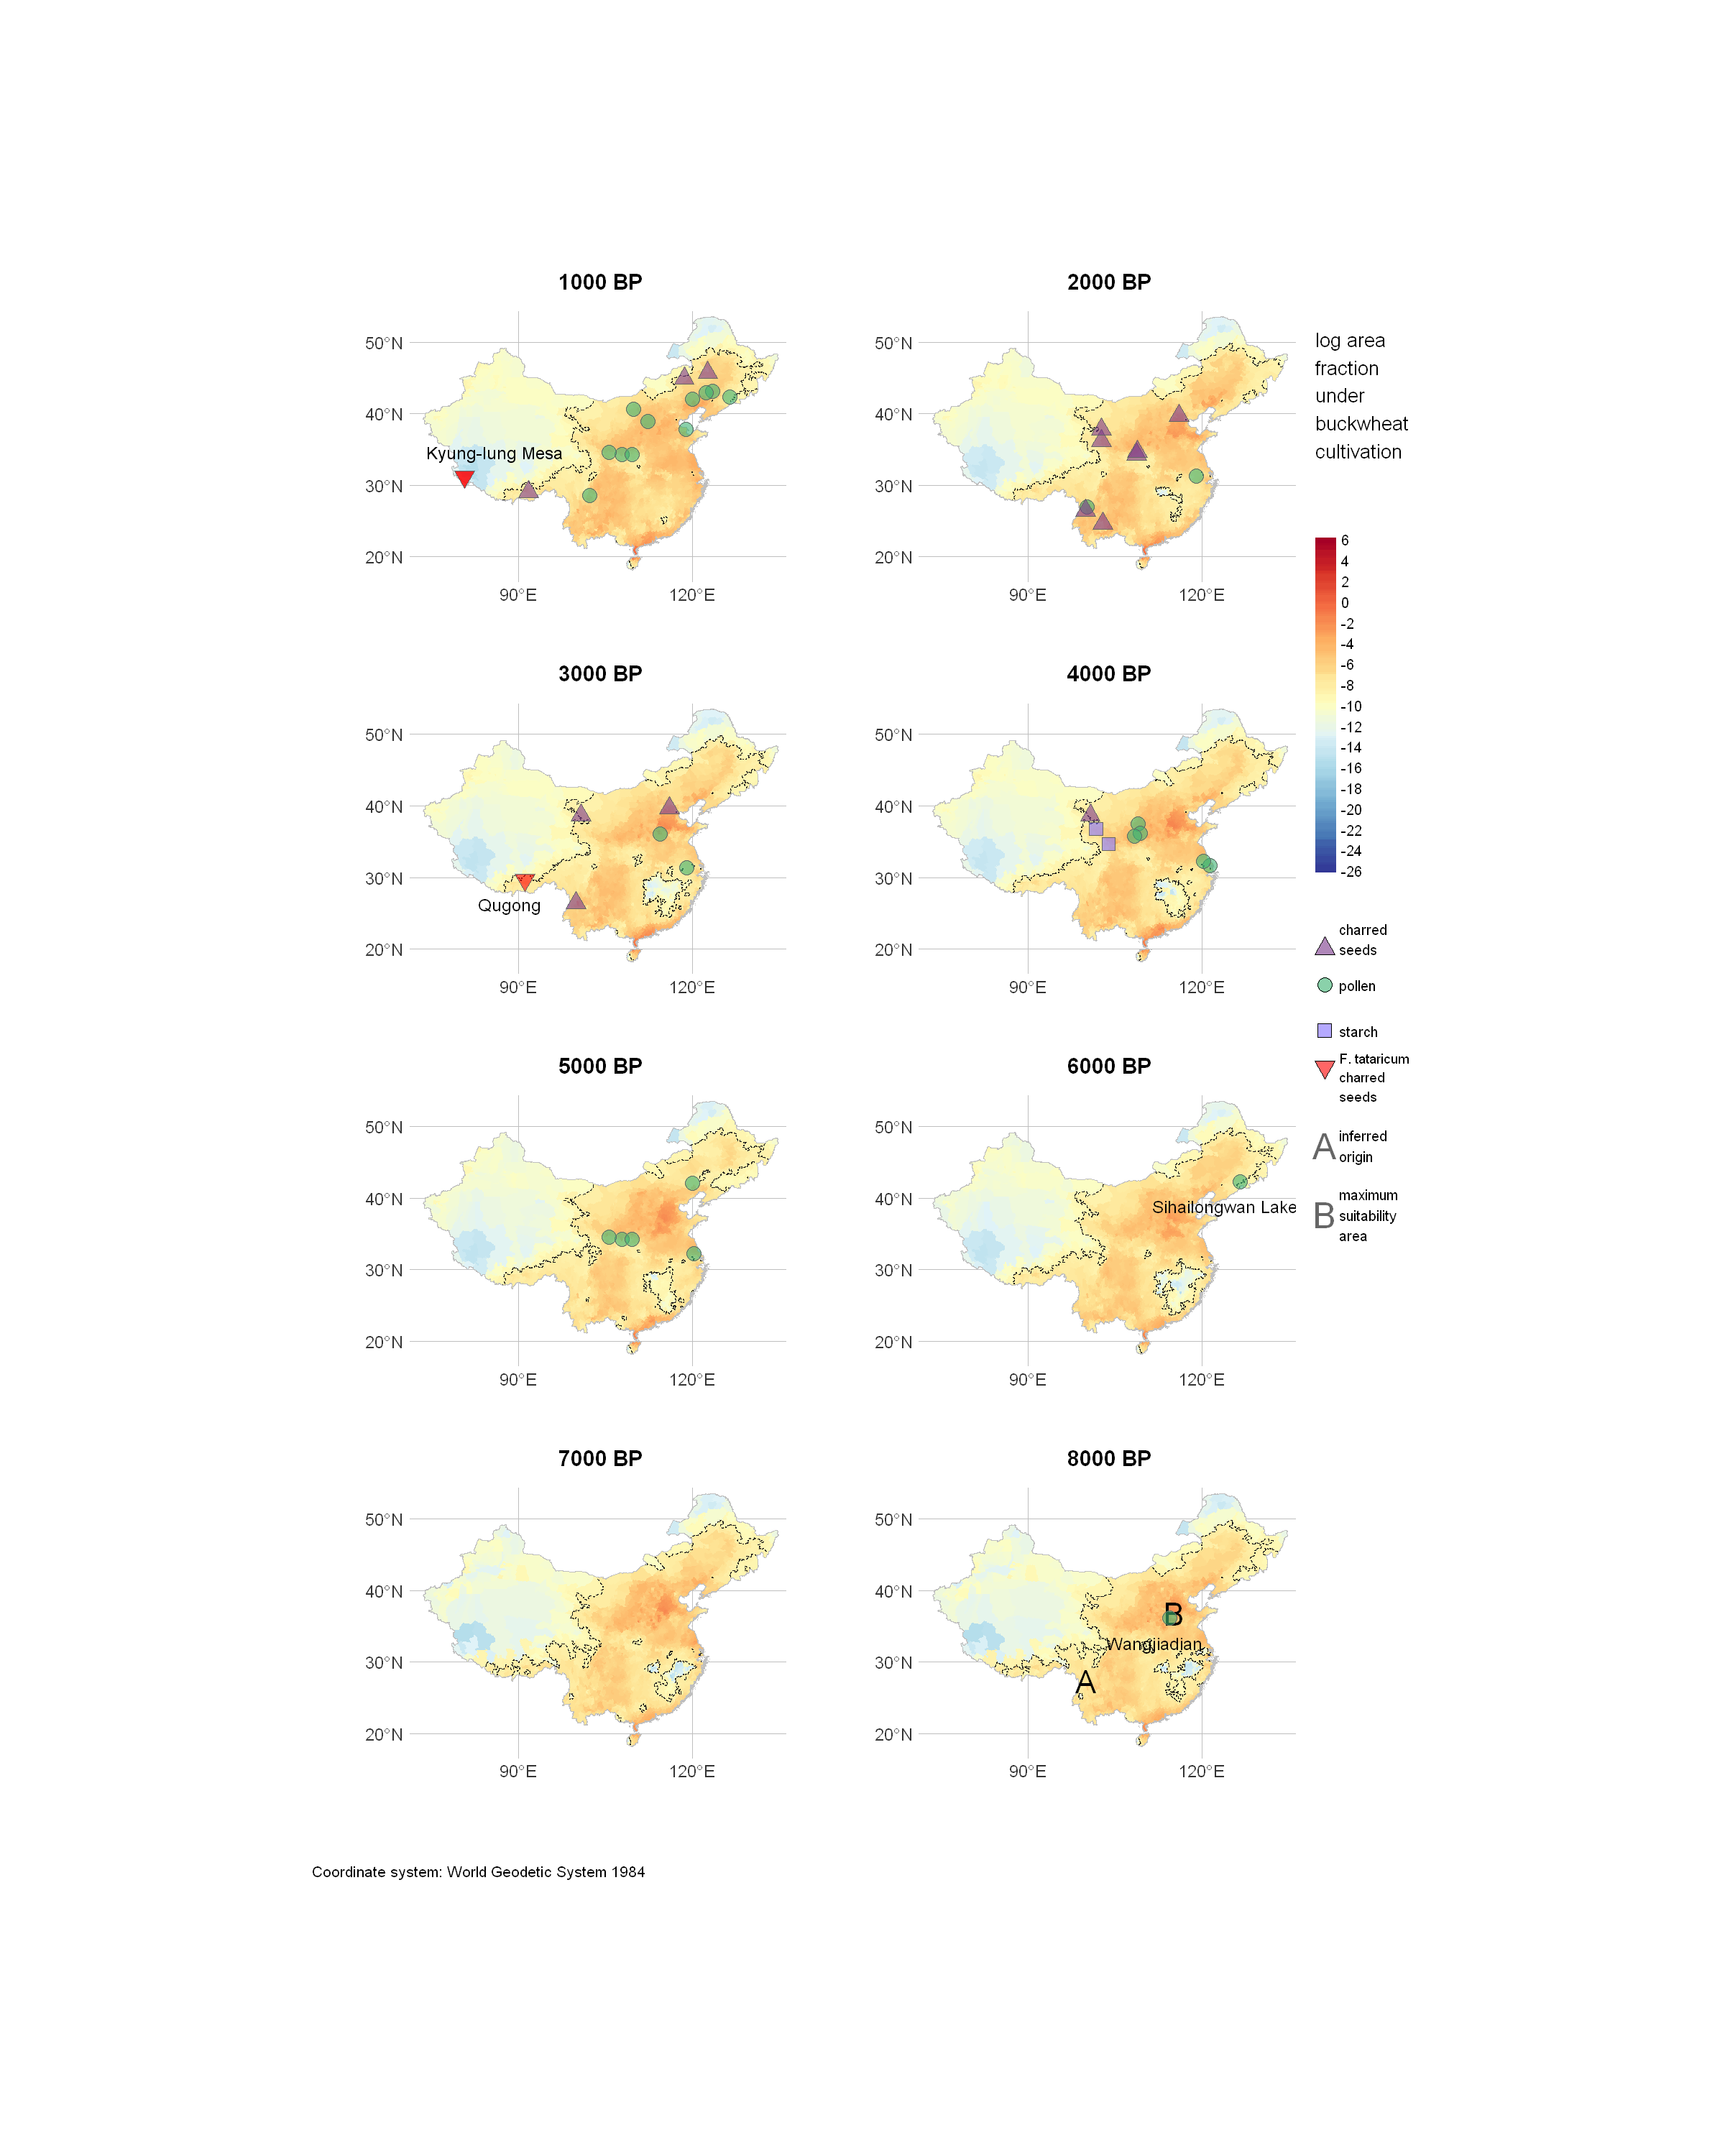

In [72]:
# Optionally plot in jupyter
#options(repr.plot.width=12.5,repr.plot.height=16.03,repr.plot.res=300)
pred_maps

In [ ]:
width=17.4
height=23.4
tmap_save(tm = pred_maps,filename = path2predMaps,width = width,height = height,units = "cm",dpi = 600)

## Distribution of environmental conditions over time compared against the suitability of buckwheat sites

In [88]:
### Prepare county data

# Get info about country's area 
china@data$area <- areaPolygon(china)
# Gather data by period and get area for each county
predByPeriod <- gather(china@data,period,predictions,colnames(means))
# Change the names of the periods to more informative ones
p1<-c("present",paste(seq(1000,8000,1000),"BP"),"15 000 BP")
p2<-unique(predByPeriod$period)
for (i in 1: length(p1)){predByPeriod$period[predByPeriod$period==p2[i]]<-p1[i]}
# Set period to factors and subset data for plotting
predByPeriod$period <- factor(predByPeriod$period,levels = unique(predByPeriod$period),ordered = TRUE)
d<-predByPeriod[,c('predictions','period','area')]

In [90]:
### Prepare locations data Set the same levels

# Set the same levels
macros$period<-factor(macros$period,levels = unique(d$period),ordered = TRUE)

# Subset relevant data
d2<-unique(macros@data[,c("period","mean","Sample_type","Site_section_name")])
d2$period<-factor(d2$period,levels = unique(d$period),ordered = TRUE)
d2$Sample_type<-tolower(d2$Sample_type)

In [102]:
violin<-plot<-ggplot()+
    geom_violin(data=d, aes(x=factor(period), y=exp(predictions),weight=area),col="darkgrey",fill="grey80")+
    geom_boxplot(data=d, aes(x=period, y=exp(predictions),weight=area),col="grey40",width=0.1,outlier.shape=NA)+
    scale_y_continuous(trans='log2',breaks=c(1e-10,1e-7,1e-4,1e-1))+
    scale_linetype_manual(name = "",values="dashed")+
    geom_hline(aes(yintercept = exp(threshold),linetype="minimum predicted value\n for sites where buckwheat\nremains were found"),colour="royalblue",size=0.5)+
    geom_point(data=d2[!is.na(d2$mean),],aes(x=period, y=exp(mean),fill=Sample_type,shape=Sample_type),cex=2.5,alpha=0.6,position=position_beeswarm())+
    geom_text(data=d2[d2$period %in% c("6000 BP","8000 BP") | d2$Sample_type =='fagopyrum tataricum charred seeds',],position = position_jitter(seed = 1),aes(x=period,y=exp(mean),label=Site_section_name),cex=2,fontface="bold")+
    scale_fill_manual(name="",values=c("mediumseagreen","mediumorchid4","slateblue1","red"),drop=FALSE)+ 
    scale_shape_manual(name="",values=c(21,24,22,25),drop=FALSE)+ 
    theme_classic()+
    labs(y = "PREDICTED VALUE\n(proportion of the area under buckehwat cultivation)\n")+
    theme(
      axis.title.y=element_text(size=6,face="bold"),
      axis.text=element_text(size=7),
      axis.title.x=element_blank(),
      legend.position="bottom",
      legend.title = element_blank(),
      legend.text = element_text(size = 6),
      legend.key.width = unit(0.5,"cm"))+
guides(colour = guide_legend(nrow = 1))

Warning message:
"Removed 8 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 8 rows containing non-finite values (stat_boxplot)."


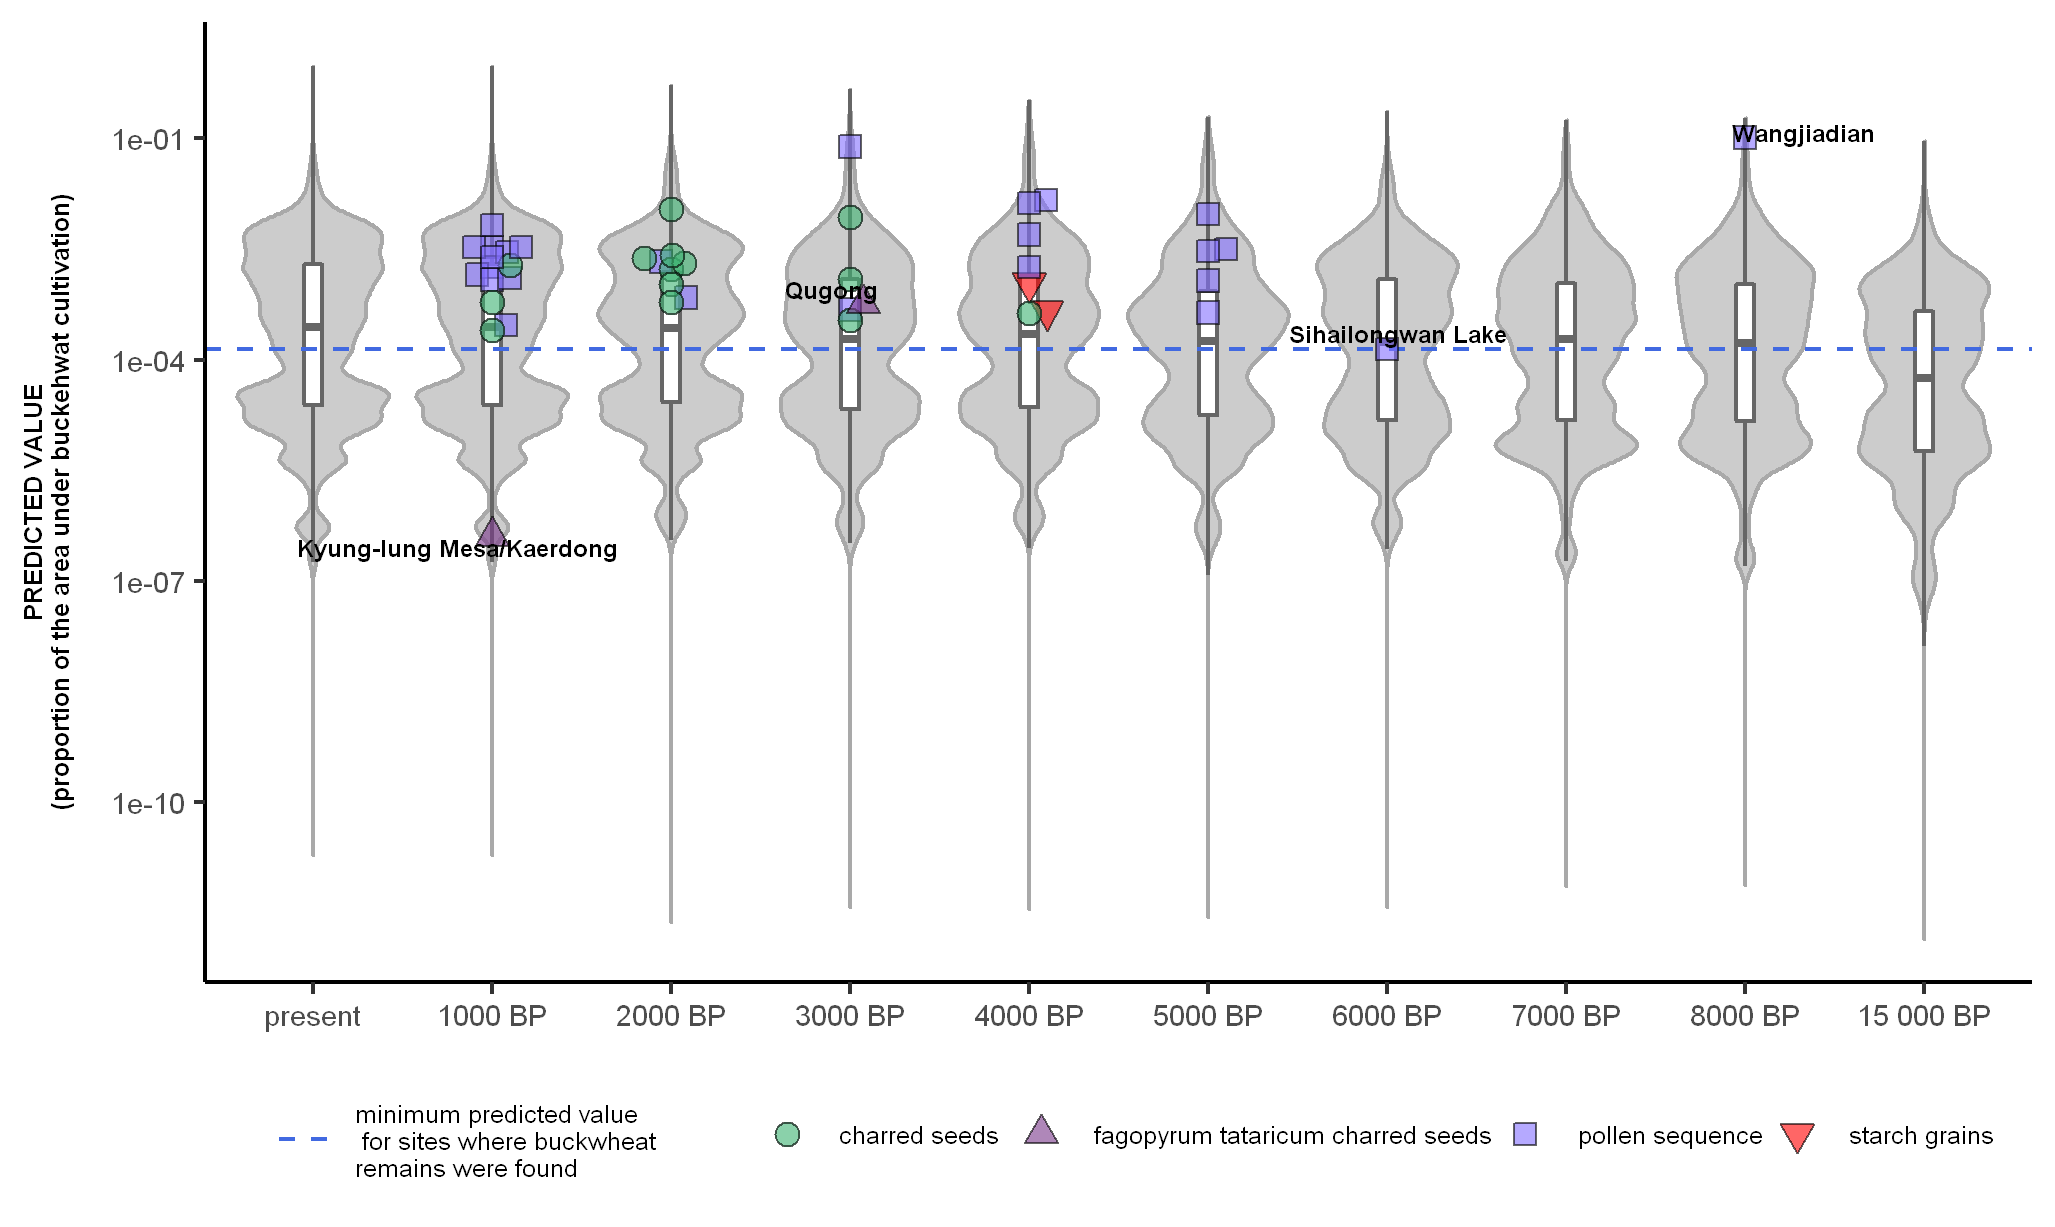

In [103]:
### Optionally also plot in jupyter
#options(repr.plot.width=6.85,repr.plot.height=4.09,repr.plot.res=300)
violin

In [ ]:
width=17.4
height=10.4
ggsave(violin,filename = path2violin,width = width,height = height,units = "cm",dpi = 600,device="tiff")